<a href="https://datamics.com/de/courses/"><img src=../DATA/bg_datamics_top.png></a>

<em text-align:center>© Datamics</em>
# GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Using TensorFlow backend.


## Die Daten

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../03-Convolutional-Neural-Networks/MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


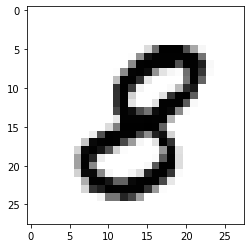

In [3]:
plt.imshow(mnist.train.images[5].reshape(28,28),cmap='Greys')

# Das Netzwerk

Hilfreiche Links:

https://stackoverflow.com/questions/45307072/using-leaky-relu-in-tensorflow

## Der Generator

In [4]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse): 
        hidden1 = tf.layers.dense(inputs=z,units=128)
        hidden1 = tf.nn.leaky_relu(hidden1, alpha=0.01)
        
        # Alternative für Leaky Relu Aktivierungsfunktion:
        # hidden1 = tf.maximum(0.01*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.nn.leaky_relu(hidden2, alpha=0.01)
        
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh) 

        return output
    

## Der Diskriminator

In [5]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        # Leaky Relu
        hidden1 = tf.nn.leaky_relu(hidden1, alpha=0.01)
        
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.nn.leaky_relu(hidden2, alpha=0.01)
        
        logits = tf.layers.dense(hidden2,units=1) # Echte Daten oder gefälscht  0 oder 1 
        output = tf.sigmoid(logits)
    
        return output, logits

### Platzhalter

In [6]:
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

### Generator

In [7]:
tf.reset_default_graph() 
G = generator(z)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


ValueError: Tensor("gen/dense/kernel:0", shape=(100, 128), dtype=float32_ref) must be from the same graph as Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32).

### Diskriminator 

In [ ]:
D_output_real , D_logits_real = discriminator(real_images)

In [ ]:
D_output_fake, D_logits_fake = discriminator(G,reuse=True)

### Verlustfunktion

In [ ]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [ ]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9)) 
tf.ones

In [ ]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

In [ ]:
D_loss = D_real_loss + D_fake_loss

In [ ]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

### Optimierer

In [ ]:
learning_rate = 0.001

In [ ]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

In [ ]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [ ]:
d_vars

## Trainings Session

In [ ]:
batch_size = 100
epochs = 500
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [ ]:
# Ein Sample pro Epoche speichern
samples = []

In [ ]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall eine Epoche ist ein ganzer Lauf durch die Trainingsdaten
    for e in range(epochs):
        # // zeigt die klassische Einteilung
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Batch von Bildern erfassen
            batch = mnist.train.next_batch(batch_size)
            
            # Bilder holen, umgestalten und skalieren, um sie an D zu übergeben.
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (zufällige latente Rauschdaten für den Generator)
            # -1 bis 1 wegen der tanh Aktivierung
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Optimierer laufen lassen, keine Notwendigkeit die Ausgaben zu speichern, wir werden sie nicht verwenden.
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
            
        print("Gerade bei Epoche {} von {} total...".format(e+1, epochs))
        
        # Ausschnitt aus dem Generator während des Trainings zur anschließenden Betrachtung
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z ,reuse=True),feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        
#         saver.save(sess, './models/500_epoch_model.ckpt')

In [ ]:
saver = tf.train.Saver(var_list=g_vars)

new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'./models/500_epoch_model.ckpt')
    
    for x in range(5):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

In [ ]:
plt.imshow(samples[0].reshape(28,28),cmap='Greys')